# Missing Values

A missing values occur when no data value is stored for the variable in an observation. They are represented most of the time by NULL or None. Not handling them can lead to unexpected results (For example some ML algorithms can not perform well because they can not handle missing values) and even worst, it can lead to wrong assumptions.

Handling them is a very important step of the Data Preparation life cycle.

There are 3 main types of missing values:
 - <b>MCAR (Missing Completely at Random)</b> : The events that lead to any particular data-item being missing occur entirely at random. For example: in IOT, because of some transmission problems, some of the data related to the sensors could be lost.
 - <b>MAR (Missing {Conditionally} at Random)</b> : The missingness is not random, but it is related to some of the observed data. For example: Some students may have not answered to some specific questions of a test because they were absent during the related lesson.
 - <b>MNAR (Missing not at Random)</b> : The value of the variable that’s missing is related to the reason it’s missing. If someone didn’t subscribe to a loyalty program, we can leave an empty cell to avoid useless data storing.

Depending on the Missing Values Types, the imputation will be more or less obvious. For example, when dealing with MCAR it is possible to use mathematical aggregations to impute the missing values. For MNAR, we can simply create another category whereas for MAR we will need to investigate to find the best way to impute the data. To see how to handle missing values in Vertica ML Python, we will use the well-known 'Titanic' dataset.

In [13]:
from vertica_ml_python import *
vdf = vDataFrame("titanic")
print(vdf)

,survived,boat,ticket,embarked,home.dest,sibsp,fare,sex,body,pclass,age,name,cabin,parch
0,0,None,113781,S,"Montreal, PQ / Chesterville, ON",1,151.55,female,None,1,2.0,"Allison, Miss. Helen Loraine",C22 C26,2
1,0,None,113781,S,"Montreal, PQ / Chesterville, ON",1,151.55,male,135,1,30.0,"Allison, Mr. Hudson Joshua Creighton",C22 C26,2
2,0,None,113781,S,"Montreal, PQ / Chesterville, ON",1,151.55,female,None,1,25.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",C22 C26,2
3,0,None,112050,S,"Belfast, NI",0,0.0,male,None,1,39.0,"Andrews, Mr. Thomas Jr",A36,0
4,0,None,PC 17609,C,"Montevideo, Uruguay",0,49.5042,male,22,1,71.0,"Artagaveytia, Mr. Ramon",None,0
,...,...,...,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: titanic, Number of rows: 1234, Number of columns: 14


We can look at all the missing values using the 'count' method.

In [14]:
vdf.count()

,count,percent
"""survived""",1234.0,100.0
"""ticket""",1234.0,100.0
"""sibsp""",1234.0,100.0
"""sex""",1234.0,100.0
"""pclass""",1234.0,100.0
"""name""",1234.0,100.0
"""parch""",1234.0,100.0
"""fare""",1233.0,99.919
"""embarked""",1232.0,99.838
"""age""",997.0,80.794


<object>

The missing values of the 'boat' features are MNAR. Indeed, missing values of this feature represents passengers who didn't pay for the 'lifeboat' option. We can replace all the missing values by a new category using the 'fillna' method.

In [15]:
vdf["boat"].fillna("No Lifeboat")
vdf["boat"]

795 element(s) was/were filled


,boat
0,No Lifeboat
1,No Lifeboat
2,No Lifeboat
3,No Lifeboat
4,No Lifeboat
,...


<object>  Name: boat, Number of rows: 1234, dtype: varchar(100)

Missing values of the feature 'age' seems to be MCAR so the best way to impute them is using mathematical aggregations. Let's impute the age using the averaged age of the passenger having the same sex and class.

In [16]:
vdf["age"].fillna(method = "avg",
                  by = ["pclass", "sex"])
vdf["age"]

237 element(s) was/were filled


,age
0,36.0
1,31.0
2,21.0
3,50.0
4,45.0
,...


<object>  Name: age, Number of rows: 1234, dtype: numeric(6,3)

The features 'embarked' and 'fare' have a very low number of missing values. Instead of using a technique to impute them, we can drop them using the 'dropna' method.

In [17]:
vdf["fare"].dropna()
vdf["embarked"].dropna()

1 element(s) was/were filtered
2 element(s) was/were filtered


,survived,boat,ticket,embarked,home.dest,sibsp,fare,sex,body,pclass,age,name,cabin,parch
0,1,8,PC 17760,C,"New York, NY / Washington, DC",0,135.6333,female,None,1,36.0,"Young, Miss. Marie Grice",C32,0
1,1,3,16966,C,None,0,134.5,female,None,1,31.0,"Wilson, Miss. Helen Alice",E39 E41,0
2,1,8 10,113795,S,"Duluth, MN",0,26.55,female,None,1,21.0,"Willard, Miss. Constance",None,0
3,1,4,113503,C,"Elkins Park, PA",1,211.5,female,None,1,50.0,"Widener, Mrs. George Dunton (Eleanor Elkins)",C80,1
4,1,8,36928,S,"Youngstown, OH",1,164.8667,female,None,1,45.0,"Wick, Mrs. George Dennick (Mary Hitchcock)",None,1
,...,...,...,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: titanic, Number of rows: 1231, Number of columns: 14

Many techniques are available when using the 'fillna' method.

In [19]:
help(vdf["embarked"].fillna)

Help on method fillna in module vertica_ml_python.vcolumn:

fillna(val=None, method:str='auto', by:list=[], order_by:list=[], print_info:bool=True) method of vertica_ml_python.vcolumn.vColumn instance
    ---------------------------------------------------------------------------
    Fills the vcolumn missing elements using specific rules.
    
    Parameters
    ----------
    val: int/float/str, optional
            Value used to impute the vcolumn.
    method: dict, optional
            Method used to impute the missing values.
                    auto    : Mean for the numerical and Mode for the categorical vcolumns.
                    bfill   : Back Propagation of the next element (Constant Interpolation).
                    ffill   : Propagation of the first element (Constant Interpolation).
                    mean    : Average.
                    median  : Median.
                    mode    : Mode (most occurent element).
                    0ifnull : 0 when the vcolumn is 

Vertica ML Python will adapt the SQL code generation to only generate what is needed.

In [20]:
print(vdf.current_relation())

(
   SELECT
     * 
   FROM
 (
   SELECT
     "survived",
     COALESCE("boat", 'No Lifeboat') AS "boat",
     "ticket",
     "embarked",
     "home.dest",
     "sibsp",
     "fare",
     "sex",
     "body",
     "pclass",
     COALESCE("age", AVG("age") OVER (PARTITION BY "pclass", "sex")) AS "age",
     "name",
     "cabin",
     "parch" 
   FROM
 "public"."titanic") 
VERTICA_ML_PYTHON_SUBTABLE WHERE ("fare" IS NOT NULL) AND ("embarked" IS NOT NULL)) 
VERTICA_ML_PYTHON_SUBTABLE


Depending on the circumstances, we will need to investigate to find the most suitable solution. Let's take the example of the following dataset.

In [24]:
Accidents = vDataFrame("Accidents_Maroc")
print(Accidents)

,lon,lat,highway_id,highway_position_km
0,None,None,3,216
1,None,None,3,216
2,None,None,3,216
3,None,None,3,216
4,None,None,3,216
,...,...,...,...


<object>  Name: accidents_maroc, Number of rows: 332099, Number of columns: 4

We have access to the latitude and longitude of the Morocco car accidents.

In [27]:
Accidents.count()

,count,percent
"""highway_id""",332099.0,100.0
"""highway_position_km""",332099.0,100.0
"""lon""",303919.0,91.515
"""lat""",303919.0,91.515


<object>

Many longitude and latitude values are missing. However, we also know the Highway ID and the position of the car in the concerning highway. Having these information, we can use Interpolation to impute the missing values.

In [29]:
# First Propagation
Accidents["lat"].fillna(method = "ffill",
                        by = ["highway_id"],
                        order_by = ["highway_position_km"])
Accidents["lon"].fillna(method = "ffill",
                        by = ["highway_id"],
                        order_by = ["highway_position_km"])
# Back Propagation
Accidents["lat"].fillna(method = "bfill",
                        by = ["highway_id"],
                        order_by = ["highway_position_km"])
Accidents["lon"].fillna(method = "bfill",
                        by = ["highway_id"],
                        order_by = ["highway_position_km"])

10545 element(s) was/were filled
10545 element(s) was/were filled
14009 element(s) was/were filled
14009 element(s) was/were filled


,lon,lat,highway_id,highway_position_km
0,-6.5501292918,34.015600878,2,15
1,-6.5501292918,34.015600878,2,15
2,-6.5501292918,34.015600878,2,15
3,-6.5501292918,34.015600878,2,15
4,-6.5501292918,34.015600878,2,15
,...,...,...,...


<object>  Name: accidents_maroc, Number of rows: 332099, Number of columns: 4

Some values are still missing because we do not have any longitude and latitude of some specific highways.

In [30]:
Accidents.count()

,count,percent
"""highway_id""",332099.0,100.0
"""highway_position_km""",332099.0,100.0
"""lon""",328473.0,98.90815690501928
"""lat""",328473.0,98.90815690501928


<object>

We can still investigate and find the longitude and latitude of the different cities highway and use an interpolation to fill the missing values. We have the following information:

<b>Autoroute A4 Berrechid - Beni Mellal (Berrechid - Khouribga - Beni Mellal)</b>
 - Beni Mellal: lat = 32.339444 lon = -6.360833
 - Khouribga: lat = 32.886023 lon = -6.9208655
 - Berrechid: lat = 33.26553 lon = -7.58754
 
<b>Route 103 El Jadida information</b>
 - El Jadida: lat = 33.233334 lon = -8.500000

Let's do the interpolations.

In [32]:
new_loc  = "CASE " 
new_loc += "WHEN (highway_id = 4 AND highway_position_km <= 77) THEN 33.26553 * (1 - highway_position_km / 77) + 32.886023 * (highway_position_km / 77) "
new_loc += "WHEN (highway_id = 4 AND highway_position_km >= 77) THEN 32.886023 * (1 - (highway_position_km - 77) / 95) + 32.339444 * ((highway_position_km - 77) / 95) "
new_loc += "WHEN (highway_id = 103) THEN 33.2415617419 * (1 - highway_position_km / 5) + 33.233334 * (highway_position_km / 5) "
new_loc += "ELSE {} END"
Accidents["lat"].apply(new_loc)
new_loc  = "CASE "
new_loc += "WHEN (highway_id = 4 AND highway_position_km <= 77) THEN -7.58754 * (1 - highway_position_km / 77) + -6.9208655 * (highway_position_km / 77) "
new_loc += "WHEN (highway_id = 4 AND highway_position_km >= 77) THEN -6.9208655 * (1 - (highway_position_km - 77) / 95) + -6.360833 * ((highway_position_km - 77) / 95) "
new_loc += "WHEN (highway_id = 103) THEN - 8.3952503827 * (1 - highway_position_km / 5) - 8.500000 * (highway_position_km / 5) "
new_loc += "ELSE {} END"
Accidents["lon"].apply(new_loc)

,lon,lat,highway_id,highway_position_km
0,-6.5501292918,34.015600878,2,15
1,-6.5501292918,34.015600878,2,15
2,-6.5501292918,34.015600878,2,15
3,-6.5501292918,34.015600878,2,15
4,-6.5501292918,34.015600878,2,15
,...,...,...,...


<object>  Name: accidents_maroc, Number of rows: 332099, Number of columns: 4

The following map can be obtained before the missing values imputation.

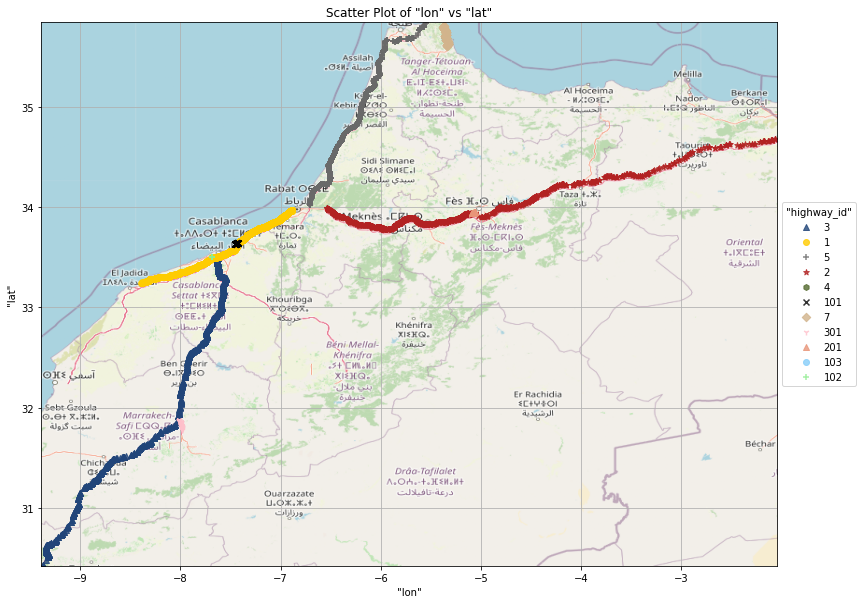

In [26]:
%matplotlib inline
Accidents.scatter(["lon", "lat"], 
                  catcol = "highway_id",
                  max_cardinality = 100,
                  img = "adm-map.png")

And the following map can be obtained after the interpolations. 

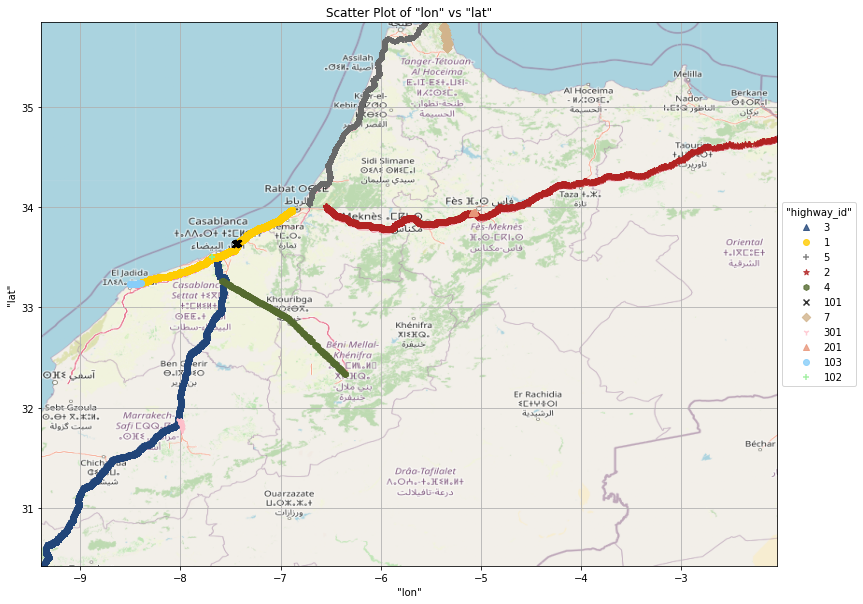

In [34]:
Accidents.scatter(["lon", "lat"], 
                  catcol = "highway_id",
                  max_cardinality = 100,
                  img = "adm-map.png")

It is very important to understand the data to do the correct missing values imputations. After this very important step, it can be very useful to encode some variables. Indeed, data Science loves generality. Our next lesson will be focused on features encoding.